In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
from scipy.linalg import circulant
from models import HopfieldNetwork, TSP, CompleteGraph

## Steps to reproduce hopfield tsp paper
1. Encode TSP into Hopfield Network to get energy function
2. Apply Simulated Annealing to check for correctness of the implementation

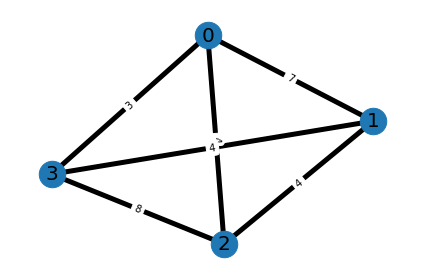

In [2]:
# Creating an examplease graph
G = CompleteGraph(4)
G.draw_graph()

In [3]:
#Creating a TSP instance and encode it into a Hopfield Network
graph = G.get_graph()
tsp = TSP(graph)
hopfield = HopfieldNetwork(tsp.T, tsp.I)

In [4]:
#Get the energy using the Christofides algorithm to compare with our results
solution = tsp.get_encoding(nx.approximation.christofides(graph)[:-1])
res = hopfield.compute_energy(solution, debug=True)
print("Energy of optimal solution:", res)
print(tsp.interpret(solution))
print("Actual best tour length (HEURISTIC!!):",tsp.get_cost(solution))

[1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
First term (inhibitory row connections): 0.0
First term (inhibitory column connections): 0.0
First term (Data term): 30.0
First term (global inhibitory connections): 640.0
Second term (Magnetic Field term): 640.0
Energy (with constant term): 15.0
Constant term: 320
If V is a valid tour then the energy with the constant term is equal to the tour length!
Energy of optimal solution: -305.0
[0. 2. 1. 3.]
Actual best tour length (HEURISTIC!!): 15


### Solving it with simulated annealing

In [5]:
from scipy.optimize import dual_annealing

In [6]:
l_bound = [0] * tsp.n**2
u_bound = [1] * tsp.n**2
REPEATS = 5
print("Repeat:", 1)
solution = dual_annealing(hopfield.compute_energy, bounds=list(zip(l_bound, u_bound)), maxiter=100)
for i in range(1, REPEATS):
    print("Repeat:", i+1)
    tmp = dual_annealing(hopfield.compute_energy, bounds=list(zip(l_bound, u_bound)), maxiter=100)
    if tmp.fun < solution.fun:
        solution = tmp

Repeat: 1
Repeat: 2
Repeat: 3
Repeat: 4
Repeat: 5


In [7]:
print(tsp.interpret(solution.x))
print(solution)
print("BEST ENERGY VALUE (without offset):", hopfield.compute_energy(solution.x))
print("ACTUAL TOUR LENGTH:", tsp.get_cost(solution.x))

[3. 1. 2. 0.]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -305.7999999999999
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
     nit: 100
    nfev: 3813
    njev: 36
    nhev: 0
BEST ENERGY VALUE (without offset): -305.0
ACTUAL TOUR LENGTH: 15
